# MLP with Molecular Fingerprint

앞선 강의에서 neural network의 가장 기본적인 형태인 Multilayer Perceptron(MLP)의 구조에 대해서 배워보았습니다. 이번 시간에는 분자를 표현하는 방법 중 하나인 molecular fingerprint를 MLP의 input으로 사용하여 분자의 lipophilicity를 예측하는 코드를 작성해봅니다.

## 1. Dataset과 DataLoader 준비하기

`torch.utils.data.Dataset`과 `torch.utils.data.DataLoader` 클래스는 pytorch에서 데이터 파일을 관리하고 training을 위한 batch 형태로 넘겨주는 역할을합니다. 지난 튜토리얼에서 보았던 CIFAR-10 dataset과 dataloader는 torchvision이라는 pytorch의 이미지 데이터 및 프로세싱을 관리하는 패키지에 이미 포함되어있었습니다. 그러나 분자 데이터는 pytorch에서 제공하지 않기에, lipophilicity 데이터 csv 파일을 이용하여 custom dataset과 dataloader를 만들어 사용해야합니다.


### 1.1 데이터의 형태 알기
먼저 wget 명령어로 lipophilicity csv 데이터 파일을 받도록합시다. IPython내에서 리눅스 명령어를 실행시키기 위해서는 맨 앞에 `!`를 붙여주시면 됩니다.

In [3]:
!wget -q "http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/Lipophilicity.csv" -O Lipophilicity.csv

데이터 관리를 위한 `pandas` 패키지를 이용하여 이 데이터가 어떠한 형태를 가지고 있는지 알아봅시다.

`pandas`는 `dataframe`의 형태로 데이터를 관리합니다. 다운로드 된 csv파일로부터 만든 `dataframe`은 분자의 smiles representation과 lipophilicity 값을 행으로써 가지고 있습니다.

In [10]:
import pandas as pd

df = pd.read_csv('Lipophilicity.csv')
df

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


### 1.2 smiles로부터 molecular fingerprint 만들기

smiles string들로부터 molecular fingerprint를 만들어봅시다. 이를 위해서는 화학 관련 패키지 `rdkit`을 사용합니다.

우리의 데이터프레임에 `fp`행이 추가되었고, 이 행은 각 분자들의 2048 길이의 molecular fingerprint vector를 가지고 있습니다.

In [20]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

fps = []
for i, smiles in enumerate(df["smiles"]):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    fps.append(arr)
    
df["fp"] = fps
df

,CMPD_CHEMBLID,exp,smiles,fp
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 1.3 Train, Validation, Test set으로 나누기

역시 데이터 관리를 위한 패키지인 `sklearn`의 `train_test_split` 함수를 이용하여 우리의 전체 `dataframe`을 train, validation, test `dataframe`으로 나누어봅시다. 물론 `train_test_split` 함수를 사용하지 않고도 `dataframe`을 나누는 것이 가능합니다.

전체 데이터를 8:1:1의 비율로 각각 train, validation, test `dataframe`으로 나누었습니다. 그 결과 train에는 3359개, validation과 test에는 421, 420개의 분자가 랜덤하게 배정되었습니다.

In [15]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.1, random_state=123)
train, val = train_test_split(train_val, test_size=0.1/0.9, random_state=123)

dataframes = {
    "train": train,
    "val": val,
    "test": test
}

dataframes

{'train':       CMPD_CHEMBLID   exp                                             smiles  \
 1369   CHEMBL199237  2.70                 O=C(NCc1ccccn1)c2ccc(Oc3ccccc3)cc2   
 3084   CHEMBL277863  2.05  COC(=O)N1CCN([C@H](CN2CCCC2)C1)C(=O)Cc3ccc(Cl)...   
 2141  CHEMBL1824036 -0.51  CS(=O)(=O)c1ccc2OCC(=O)N(CCN3CCC(CC3)NCc4ccc5O...   
 3741    CHEMBL87266  1.35  Cc1cc(N)c2cc(NC(=O)CC(=O)Nc3ccc4nc(C)cc(N)c4c3...   
 2192   CHEMBL513370  2.36  COc1ccc(N(C(C(=O)NC[C@@H](C)O)c2ccccc2F)C(=O)c...   
 ...             ...   ...                                                ...   
 3180   CHEMBL578061  4.06                     N(c1ccccc1)c2ccnc(Nc3ccccc3)n2   
 266        CHEMBL97  2.16          COc1ccc2nccc([C@H](O)C3CC4CCN3CC4C=C)c2c1   
 2398   CHEMBL138649  3.60                     Oc1ccc2OC(=CC(=O)c2c1)c3ccccc3   
 2073   CHEMBL272705  2.21            C[C@H](CO)Nc1nc(SCc2occc2)nc3NC(=O)Sc13   
 2480   CHEMBL177611  0.60                 Clc1ccc(cc1)C(=O)N[C@H]2CN3CCC2CC3   
 
                 

### 1.4 Custom Dataset 만들기

이제 `dataframe`들을 감싸는 custom 데이터셋을 만들어봅시다. 모든 custom 데이터셋은 `torch.utils.data.Dataset`을 상속하고, 데이터셋의 길이를 반환하는 `__len__` 메서드와 `index`번째 아이템을 요청하였을때 무엇이 반환되는지 결정하는 `__getitem__` 메서드를 작성해야합니다.

우리의 데이터셋은 각자 `pandas dataframe`을 가지고 `index`번째 아이템을 요청시 데이터프레임의 `index`번째 분자의 molecular fingerprint와 lipophilicity 값을 반환합니다.

In [39]:
from torch.utils.data import Dataset

class FPDataset(Dataset):
    
    def __init__(self, df):
        self.fps = list(df["fp"])
        self.exp = list(df["exp"].values)
        
    def __len__(self):
        return len(self.fps)
    
    def __getitem__(self, index):
        return self.fps[index], self.exp[index]
    
datasets = {
    "train": FPDataset(dataframes["train"]),
    "val": FPDataset(dataframes["val"]),
    "test": FPDataset(dataframes["test"]),
}

datasets

{'train': <__main__.FPDataset at 0x7ff2a3f1ab10>,
 'val': <__main__.FPDataset at 0x7ff2a3f1add0>,
 'test': <__main__.FPDataset at 0x7ff2574dcdd0>}

우리의 데이터셋이 molecular fingerprint와 lipophilicity 값을 반환하는 것을 다음과 같이 확인할 수 있습니다.

In [40]:
datasets["train"][0]

(array([0., 0., 0., ..., 0., 0., 0.]), 2.7)

## 2. MLP Model 만들기

### 2.1 `nn.Module`을 상속하여 custom Model 만들기

`pytoch`를 통해 MLP model을 만들어봅시다. 모든 custom model 또는 sub-model은 `torch.nn.Module`을 상속하고 `forward` 함수를 작성해야합니다. `forward` 함수는 input 데이터가 어떠한 레이어들과 activation function들을 통과할지에 대한 정보를 담고 있습니다. 거의 모든 기본 레이어들과 activation function들은 `torch.nn` 모듈에 구현되어있습니다. 우리의 model의 `__init__` 함수에서는 `forward` 함수에서 사용할 레이어들과 activation function들을 미리 만들어 저장해둡니다.

`nn.Linear` object는 일반적인 fully-connected layer를 말합니다. 이는 두가지 argument를 받는데 각각 input과 output의 dimension입니다. 우리의 input molecular fingerprint는 2048 dimension이니 첫 layer의 input dimension은 반드시 2048이 되어야합니다. 또한 우리의 output은 lipophilicity 값이기 때문에 마지막 layer의 output dimension은 1이 되어야합니다.

`nn.ReLU`는 ReLU activation function입니다. `forward` 함수를 보면 하나의 레이어를 통과한 뒤 ReLU activation function을 거치는 것을 볼 수 있습니다. 그러나 맨 마지막 레이어 이후에는 이를 적용하면 안되는데, 그 이유는 output이 0보다 큰 값으로 고정되어 버리기 때문입니다.

In [180]:
import torch.nn as nn

class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(2048, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out
        
model = MLP()
model

MLP(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

### 2.2 Model을 GPU에 올리기

지난 pytorch tutorial에서 임의의 tensor 또는 model을 GPU 상에 올리는 방법을 배웠습니다. 이를 적용하여 우리의 모델을 GPU에 올려봅시다.

In [181]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [182]:
model.to(device)

MLP(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

## 3. Model을 Training하기

### 3.1 Loss와 Optimizer 생성하기

훈련을 위한 model이 준비되었습니다. 이제 이 model을 training 시키기 위해서는 사용할 loss function과 optimizer를 결정해야합니다. 역시 `torch.nn`과 `torch.optim` 모듈에 기본적인 loss function들과 optimizer들이 구현되어있습니다.

`nn.MSELoss`와 `optim.Adam`을 사용해봅시다.

`nn.MSELoss`는 mean squared error의 줄임말입니다. 예측값과 실제값의 차이의 제곱의 평균을 loss로서 사용합니다.

모든 optimizer는 SGD를 기반으로하고 다양한 기능이 추가되어있습니다. 일반적으로 잘 작동한다고 알려진 `optim.Adam`을 사용해봅시다. 모든 optimizer를 생성하기 위해서는 optimizer가 update할 parameter들과 learning rate, l2 regularization coefficient가 필요합니다. 뒤의 두 값을 적절히 설정해주고, `model.parameters()`를 통해 model의 모든 parameter들을 optimizer가 update 할 수 있도록 해줍시다.

In [183]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

### 3.2 DataLoader 만들기

`Pytorch`에서 `Dataset`과 `DataLoader`는 그 역할이 구분되어있습니다. `Dataset`의 경우 일반적으로 파일로부터 데이터를 읽어오고, 하나의 데이터 엔트리를 제공해주는 역할을 하며, `DataLoader`의 경우 기본적으로 `Dataset`이 제공하는 데이터 엔트리들을 모아 `batch`의 형태로 제공하고, 데이터를 랜덤하게 섞어서 제공하거나, 라벨별로 데이터의 비율을 조절하여 제공하는 등, training에 필요한 다양한 기능을 구현하여 제공합니다.

위에서 train, validation, test를 위한 `dataset`을 만들었으니, 각각에 해당하는 `dataloader`를 만들어줍시다.

In [184]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=256, shuffle=True),
    "val": DataLoader(datasets["val"], batch_size=256, shuffle=False),
    "test": DataLoader(datasets["test"], batch_size=256, shuffle=False)
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff20e12bb50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ff20e12bd90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ff20e12bad0>}

`DataLoader`는 iterable 한 object로 for문을 이용하여 하나의 `batch`를 얻을 수 있습니다.

하나의 `batch`의 크기가 `batch_size`라면, `DataLoaer`가 반환하는 `tensor`들의 `shape`은 `(batch_size, ...)`입니다.

In [185]:
for data in dataloaders["train"]:
    fp, exp = data
    print(fp.shape, exp.shape)

torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([256, 2048]) torch.Size([256])
torch.Size([31, 2048]) torch.Size([31])


### 3.3 Model Training

Model training을 위한 모든것이 준비되었으니, training을 시작해봅시다.

- `epoch`은 `model`이 전체 데이터셋을 모두 학습하는 것을 가리키는 단위입니다. 아래에 `epoch`이 61로 설정되어있으니 우리의 `model`은 전체 데이터셋을 총 61번 학습하게 됩니다.
- `optimizer.zero_grad()`는 `optimizer`의 gradient값들을 모두 0으로 초기화시켜 이전 gradient 계산값들이 더 이상 영향을 끼치지 못하게합니다.
- `model.train()`, `model.eval()` 함수는 `model`을 각각 `train`, `eval` 모드로 전환합니다. 특정 레이어들은 모델이 어느 모드에 있는지에 따라 다르게 행동하합니다. (ex. `nn.Dropout`) 그러한 레이어들이 정상적으로 작동하게 하기 위해서는 두 함수들을 적절한 위치에서 실행시켜야합니다.
- `outputs = model(fps)` 라인에서 `fps`가 `model`의 `forward` 함수를 통과하므로 이 과정을 forward, `train_loss.backward()` 라인에서 각 `tensor`들의 gradient가 계산되므로 이 과정을 backward라고 부릅니다.
- `optimizer.step()` 라인에서 계산된 gradient값과 learning rate에 따라 `model parameter` 값이 실제로 바뀝니다. 
- `train_losses`, `val_losses` 리스트에 각 `epoch`의 `train loss`와 `validation loss`가 저장됩니다.

In [186]:
train_losses = []
val_losses = []

for epoch in range(61):
    model.train()
    epoch_train_loss = 0.0
    for i, data in enumerate(dataloaders["train"]):
        fps, labels = data[0].to(device, torch.float), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(fps)
        train_loss = criterion(outputs, labels.view(-1, 1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloaders["val"]):
            fps, labels = data[0].to(device, torch.float), data[1].to(device)
            
            outputs = model(fps)
            val_loss = criterion(outputs, labels.view(-1, 1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["val"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch%10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Validation Loss: %.3f" %
              (epoch, epoch_train_loss, epoch_val_loss))

[Epoch 0] Train Loss: 24.117  Validation Loss: 1.557
[Epoch 10] Train Loss: 0.634  Validation Loss: 0.942
[Epoch 20] Train Loss: 0.456  Validation Loss: 1.177
[Epoch 30] Train Loss: 0.432  Validation Loss: 1.016
[Epoch 40] Train Loss: 0.359  Validation Loss: 0.890
[Epoch 50] Train Loss: 0.326  Validation Loss: 0.876
[Epoch 60] Train Loss: 0.327  Validation Loss: 0.948


## 4. 결과 분석하기

### 4.1 Loss Graph 그리기

`epoch`에 따른 `train loss`와 `validation loss`를 `list`에 저장했으므로 이를 그래프로 그려봅시다. 그래프 관련 패키지 `matplotlib`와 `seaborn`을 사용합니다.

일정 구간 이후로 `validation loss`가 `train loss`에 비해 값이 큰 것을 볼 수 있습니다. `Overfitting`이 발생했다는 것을 알 수 있습니다. 이를 해결하기 위하여 `l2 regularization coefficient`를 조절하거나 `dropout` 레이어의 `dropout rate`를 조절하는 등 다양한 방향으로 `hyperparameter tuning`을 진행할 수 있으나, 이번 강의에서는 넘어가도록 하겠습니다.

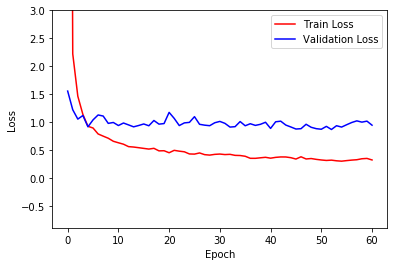

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(61)
plt.plot(epochs, train_losses, 'r')
plt.plot(epochs, val_losses, 'b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(top=3)
plt.show()

### 4.2 Test Set Inference

Test set 데이터들의 lipophilicity 값을 훈련시킨 모델을 통해 예측하고, 실제값과 비교하여 mean absolute error (MAE) 값을 알아봅시다. MAE 값 계산을 위해 `sklearn`  패키지의 `mean_absolute_error` 함수를 사용합니다. 

In [188]:
from sklearn.metrics import mean_absolute_error

model.eval()
mae = 0.0
predictions = []
truths = []
with torch.no_grad():
    for data in dataloaders["test"]:
        fps, labels = data[0].to(device, torch.float), data[1].to(device)
        
        outputs = model(fps)
        
        labels = labels.cpu().detach().numpy().tolist()
        outputs = [output[0] for output in outputs.cpu().detach().numpy().tolist()]
        
        truths += labels
        predictions += outputs
        
        mae += mean_absolute_error(labels, outputs)
    
    mae /= len(dataloaders["test"])

mae

0.7743894614990184

### 4.3 Visualization

MAE 값만으로는 우리의 모델이 얼마나 잘 작동하고 있는지 알기 어렵습니다. x축을 실제값, y축을 예측값으로하는 `scatter plot` 그래프를 통해 모델의 정확도를 눈으로 확인해봅시다.

그래프 중앙의 검은 실선은 `y=x` 그래프입니다. `scatter plot`이 이 그래프에 가깝게 밀집되어 있을 수록 모델의 정확도가 높다는 것을 알 수 있습니다.

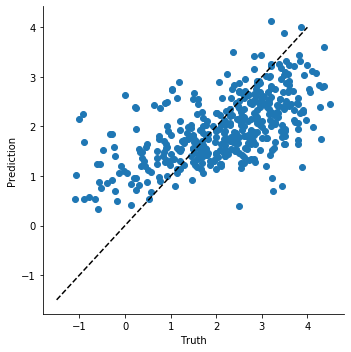

In [189]:
df_prediction = pd.DataFrame(list(zip(predictions, truths)), columns=["Prediction", "Truth"])

g = sns.FacetGrid(df_prediction, height=5)
g = g.map(plt.scatter, "Truth", "Prediction")
plt.plot(np.linspace(-1.5,4,50), np.linspace(-1.5,4,50),'k',linestyle='dashed')
plt.show()